In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

496671


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

import matplotlib.pyplot as plt

# Load sequencing analysis output

In [5]:
data_folder = r'/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM'
analysis_folder = os.path.join(data_folder, 'Analysis')

In [40]:
# Load probes:
from Bio import SeqIO

probe_filename = os.path.join(analysis_folder, 'MF1-3.fasta')
print(probe_filename)

probes = []
for record in SeqIO.parse(probe_filename, "fasta"):
    probes.append(record)
print(len(probes))

/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/Analysis/MF1-3.fasta
127389


In [41]:
probe_df = pd.DataFrame({
    'name':[ _pb.name for _pb in probes],
    'sequence': [str(_pb.seq) for _pb in probes],
})
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
127384,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127385,MF3-msBrain-immune_Mgam_ENSMUST00000238599.2_s...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127386,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127387,MF3-msBrain-immune_Zfp318_ENSMUST00000113481.9...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...


In [24]:
# load analysis 
sequence_folder = os.path.join(data_folder, '20231028_082558', 'Fastq')
alignment_stats = [os.path.join(sequence_folder, _f) for _f in os.listdir(sequence_folder) if 'stat.txt' in _f]
alignment_stats

['/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF2-amplified_S2_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF1-amplified_S1_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF3-amplified_S3_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF2-twist_S5_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF1-twist_S4_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF3-twist_S6_L001_stat.txt']

## MF1

In [128]:
# Analysis for MF1:
library_name = 'MF1'
amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(27116, 648064, 170638)

In [129]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(23.677054137778434, 0.5813541820327482)

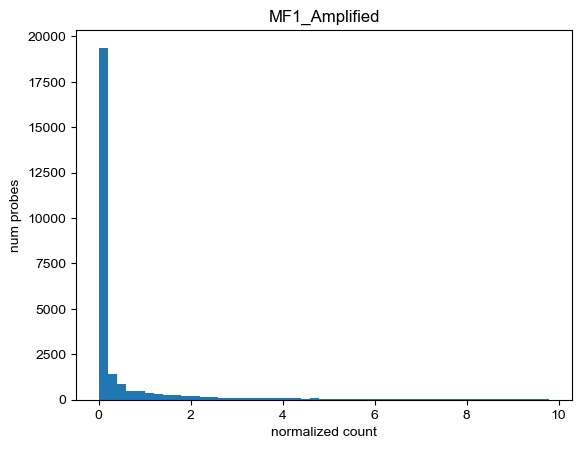

In [130]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [131]:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(27116, 322808, 54365)

In [132]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(11.770504499188672, 0.005089246201504647)

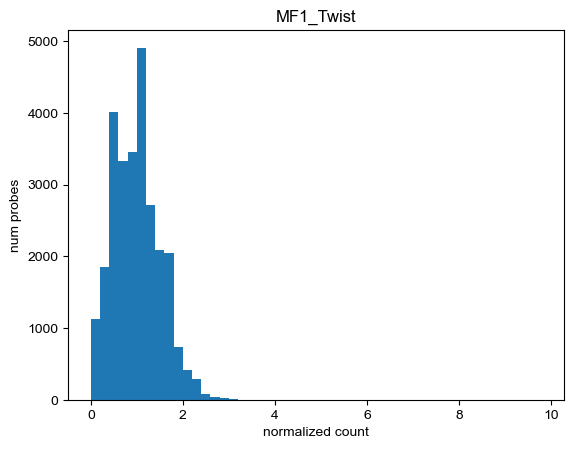

In [133]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()

## MF2

In [134]:
# Analysis for MF2:
library_name = 'MF2'
amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(66321, 884232, 67592)

In [135]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(13.319250312872242, 0.18678849836401742)

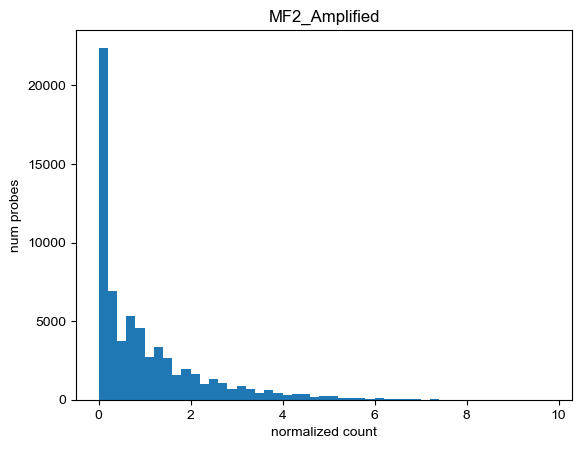

In [136]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [137]:
# Analysis for MF1:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(66321, 1090472, 72711)

In [138]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(16.427421178812143, 0.00033171996803425764)

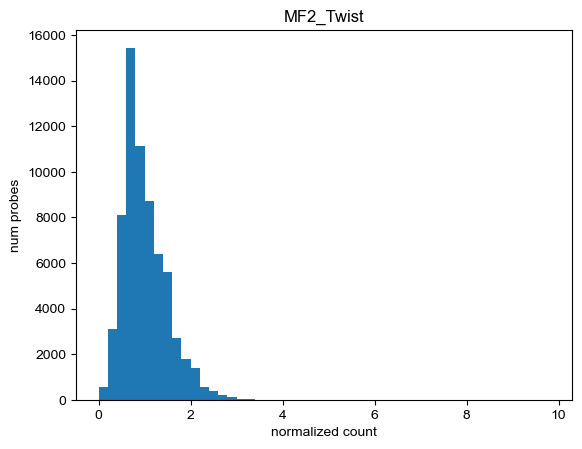

In [139]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()

## MF3

In [140]:
# Analysis for MF2:
library_name = 'MF3'
amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(33952, 22164, 2150456)

In [141]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(0.5526036757775683, 0.8373586239396795)

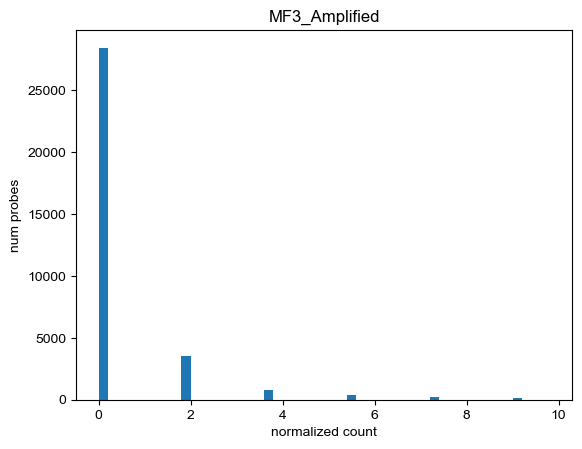

In [142]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [143]:
# Analysis for MF1:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(33952, 535886, 48991)

In [144]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(15.693272855796419, 0.0006479736098020736)

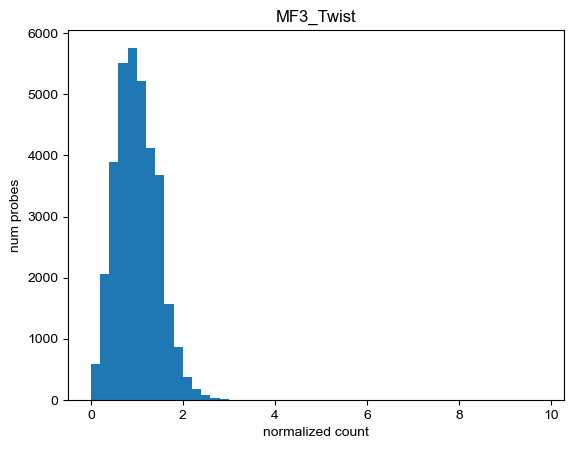

In [145]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()